# Learn2Reg OASIS Registration with VoxelMorph. GIT 2021 model.

In [1]:
%matplotlib inline
import os, sys
import glob

# third party
import tensorflow as tf
import scipy.io as sio
import numpy as np
# from keras.backend.tensorflow_backend import set_session
from scipy.interpolate import interpn
import matplotlib.pyplot as plt

In [2]:
"""
vm_dir = './voxelmorph_2018'

sys.path.append(os.path.join(vm_dir, 'src')) # add source
sys.path.append(os.path.join(vm_dir, 'ext', 'medipy-lib'))

sys.path.append( './voxelmorph_2018/voxelmorph/src/')
sys.path.append( './voxelmorph_2018/voxelmorph/ext/medipy-lib')

import medipy
import networks
from medipy.metrics import dice
import datagenerators
"""

sys.path.append( '../VoxelMorphSrc_March2022/voxelmorph-dev/')

import voxelmorph as vxm


In [3]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.vals = []
        self.std = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        self.vals.append(val)
        self.std = np.std(self.vals)

In [4]:
def dice_mhg(y_pred, y_true, nlabels):
    
    # Hay 4, 24 o 35 labels 
        
    pred = np.squeeze( y_pred )
    true = np.squeeze( y_true )
        
    # pred = y_pred[0, 0, ...] # En este caso los 1's delante son muy variables dependiendo de quien se pase
    # true = y_true[0, 0, ...]
    
    DSCs = np.zeros((nlabels, 1))
    idx = 0
    for i in range(1, nlabels+1):
        pred_i = pred == i
        true_i = true == i
        intersection = pred_i * true_i
        intersection = np.sum(intersection)
        union = np.sum(pred_i) + np.sum(true_i)
        dsc = (2.*intersection) / (union + 1e-5)
        DSCs[idx] =dsc
        idx += 1
      
    return DSCs
    
    # return np.mean(DSCs)

def dice_mhg(y_pred, y_true, nlabels):
    
    # Hay 32 labels 
        
    pred = y_pred[0, ..., 0]
    true = y_true[0, ..., 0]
    
    DSCs = np.zeros((nlabels, 1))
    idx = 0
    # for i in range(1, nlabels): --- Bug!
    for i in range(1, nlabels+1):
        pred_i = pred == i
        true_i = true == i
        intersection = pred_i * true_i
        intersection = np.sum(intersection)
        union = np.sum(pred_i) + np.sum(true_i)
        dsc = (2.*intersection) / (union + 1e-5)
        DSCs[idx] =dsc
        idx += 1
      
    return DSCs
    
    # return np.mean(DSCs)

In [10]:
import glob
import nibabel as nib

# val_dir = '/FractalExt4/MedicalImaging/NeuroImages/OasisLearn2Reg/L2R_2021_Task3_validation_skull_stripped/'

val_dir = '../../../Learn2Reg2022/imagesTr/'

val_files = sorted(glob.glob(val_dir + '*.nii.gz'))

val_files = val_files[394::]

def load_david():
    
    # print( "Cargando...", val_files[patient])
    
    # img = nib.load(val_files[patient]).get_fdata()
    
    img = nib.load('../../../../dataset/OASIS3_processed/OAS31169_d0620/T1w/orig_nu_noskull.nii.gz').get_fdata()
    
    img = img[..., np.newaxis]
    img = img[np.newaxis, ...]
    
    mm = np.max(img)
    m = np.min(img)

    img1 = (img-m) / (mm-m)

    img = nib.load('../../../../dataset/OASIS3_processed/OAS31170_d2410/T1w/orig_nu_noskull.nii.gz').get_fdata()
    
    img = img[..., np.newaxis]
    img = img[np.newaxis, ...]
    
    mm = np.max(img)
    m = np.min(img)

    img2 = (img-m) / (mm-m)
    
    
    return img1, img2



def load_oasis( patient ):
    
    print( "Cargando...", val_files[patient])
    
    img = nib.load(val_files[patient]).get_fdata()
    
    img = img[..., np.newaxis]
    img = img[np.newaxis, ...]
    
    mm = np.max(img)
    m = np.min(img)

    img = (img-m) / (mm-m)
    
    return img

# seg_dir = '/FractalExt4/MedicalImaging/NeuroImages/OasisLearn2Reg/neurite-oasis.v1.0/'

seg_dir = '../../../Learn2Reg2022/labelsTr/'

def load_oasis_seg( patient ):
    
    patient_id = val_files[patient][-16:-12]
    
    # seg_file = seg_dir + "OASIS_OAS1_%s_MR1/aligned_seg35.nii.gz" % patient_id

    seg_file = seg_dir + "OASIS_%s_0000.nii.gz" % patient_id   
    
    print( "Cargando...", patient_id )
    
    print( "Cargando...", seg_file )
    
    label = nib.load(seg_file).get_fdata()
    
    label = label[..., np.newaxis]
    label = label[np.newaxis, ...]
        
    return label


In [12]:
def voxelmorph(model_file, models_dir, moving, fixed):

    # tensorflow device handling
    gpu = 0
    device, nb_devices = vxm.tf.utils.setup_device(gpu)
    
    inshape = moving.shape[1:-1]
    nb_feats = moving.shape[-1]
    
    print(inshape)
    print(nb_feats)
    
    with tf.device(device):
        # load model and predict
        config = dict(inshape=inshape, input_model=None)
        warp = vxm.networks.VxmDense.load(os.path.join(models_dir, model_file), **config).register(moving, fixed)
        moved = vxm.networks.Transform(inshape, nb_feats=nb_feats).predict([moving, warp])    
    
    return moved, warp

In [13]:
import scipy as scp

models_dir = '../VoxelMorphSrc_March2022/BenchmarkModels'

model_name = 'vxm_dense_brain_T1_3D_mse'

model = '%s.h5' % model_name

eval_dsc_def = AverageMeter()
eval_dsc_raw = AverageMeter()

# dice = [] - Matlab
dice = np.array([]) # np.zeros( 19, 35 )

n = 0

for patient in range(395, 414):

    print( patient, patient + 1 )
    
    moving, fixed = load_david()
    
    # moving = load_oasis( n + 1 )
    # fixed = load_oasis( n )

    # movingl = load_oasis_seg( n + 1)
    # fixedl = load_oasis_seg( n )
    
    print( "Voxelmorph ..." )
    [warped, warp] = voxelmorph(model, models_dir, moving, fixed)
   

    """
    # DSC
        
    inshape = moving.shape[1:-1]
    nb_feats = moving.shape[-1]    
        
    warpedl = vxm.networks.Transform(inshape, interp_method = 'nearest', nb_feats=nb_feats).predict([movingl, warp])        
              
    DSCs_trans = dice_mhg(warpedl, fixedl, 35)
    DSCs_raw = dice_mhg(movingl, fixedl, 35)
    
    dsc_trans = np.mean(DSCs_trans)
    dsc_raw = np.mean(DSCs_raw)
    
    # dice = [dice; DSCs_trans] - Matlab
        
    if n == 0:
        dice = DSCs_trans
    else:
        dice = np.concatenate((dice, DSCs_trans), axis = 1)
        
    print('Trans dsc: {:.4f}, Raw dsc: {:.4f}'.format(dsc_trans.item(),dsc_raw.item()))    
         
    eval_dsc_def.update(dsc_trans.item(), fixed.shape[0])
    eval_dsc_raw.update(dsc_raw.item(), fixed.shape[0])
    
    n = n+1
                
    out_name = "%s_OASIS_L2R22_fixed%02d_moving%02d.mat" % ( model_name, patient, patient+1)
        
    scp.io.savemat( out_name, {'warped': warped, 'warp': warp}) 

                
# scp.io.savemat( "grid.mat", {'grid': grid.cpu().detach().numpy()} )
        
        
print('Deformed DSC: {:.3f} +- {:.3f}, Affine DSC: {:.3f} +- {:.3f}'.format(eval_dsc_def.avg,
                                                                            eval_dsc_def.std,
                                                                            eval_dsc_raw.avg,
                                                                            eval_dsc_raw.std))
    """

395 396
Voxelmorph ...
(256, 256, 256)
1
Encoder... 
vxm_dense_unet_enc_conv_0_0
vxm_dense_unet_enc_conv_1_0
vxm_dense_unet_enc_conv_2_0
vxm_dense_unet_enc_conv_3_0
Decoder... 
vxm_dense_unet_dec_conv_3_0
vxm_dense_unet_dec_conv_2_0
vxm_dense_unet_dec_conv_1_0


../VoxelMorphSrc_March2022/voxelmorph-dev/voxelmorph/tf/networks.py:126: UserWarning: int_downsize is deprecated, use the int_resolution parameter.
  warnings.warn('int_downsize is deprecated, use the int_resolution parameter.')
../VoxelMorphSrc_March2022/voxelmorph-dev/voxelmorph/tf/networks.py:131: UserWarning: unet_half_res is deprecated, use the svf_resolution parameter.
  warnings.warn('unet_half_res is deprecated, use the svf_resolution parameter.')


vxm_dense_unet_dec_conv_0_0
396 397
Voxelmorph ...
(256, 256, 256)
1
Encoder... 
vxm_dense_unet_enc_conv_0_0
vxm_dense_unet_enc_conv_1_0
vxm_dense_unet_enc_conv_2_0
vxm_dense_unet_enc_conv_3_0
Decoder... 
vxm_dense_unet_dec_conv_3_0
vxm_dense_unet_dec_conv_2_0
vxm_dense_unet_dec_conv_1_0
vxm_dense_unet_dec_conv_0_0


../VoxelMorphSrc_March2022/voxelmorph-dev/voxelmorph/tf/networks.py:126: UserWarning: int_downsize is deprecated, use the int_resolution parameter.
  warnings.warn('int_downsize is deprecated, use the int_resolution parameter.')
../VoxelMorphSrc_March2022/voxelmorph-dev/voxelmorph/tf/networks.py:131: UserWarning: unet_half_res is deprecated, use the svf_resolution parameter.
  warnings.warn('unet_half_res is deprecated, use the svf_resolution parameter.')


397 398
Voxelmorph ...
(256, 256, 256)
1
Encoder... 
vxm_dense_unet_enc_conv_0_0
vxm_dense_unet_enc_conv_1_0
vxm_dense_unet_enc_conv_2_0
vxm_dense_unet_enc_conv_3_0
Decoder... 
vxm_dense_unet_dec_conv_3_0
vxm_dense_unet_dec_conv_2_0
vxm_dense_unet_dec_conv_1_0
vxm_dense_unet_dec_conv_0_0


KeyboardInterrupt: 

In [ ]:
"""
import scipy as scp
out_name = "VoxelMorph_GIT_2021_OASIS_L2R22_DSC.mat"

scp.io.savemat( out_name, {'dice': dice})
"""

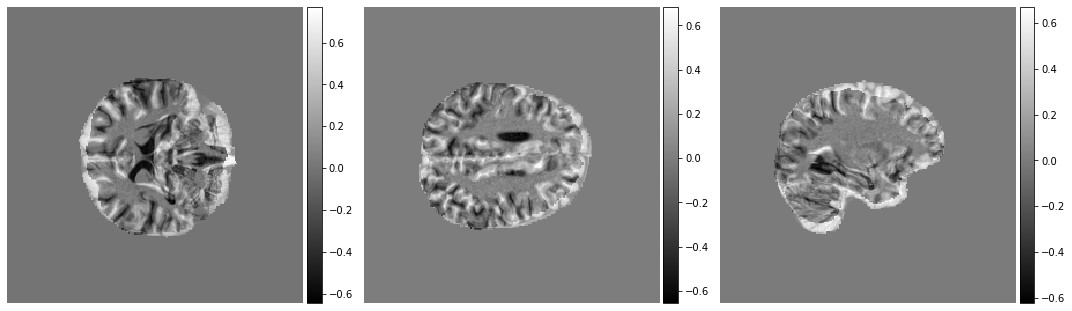

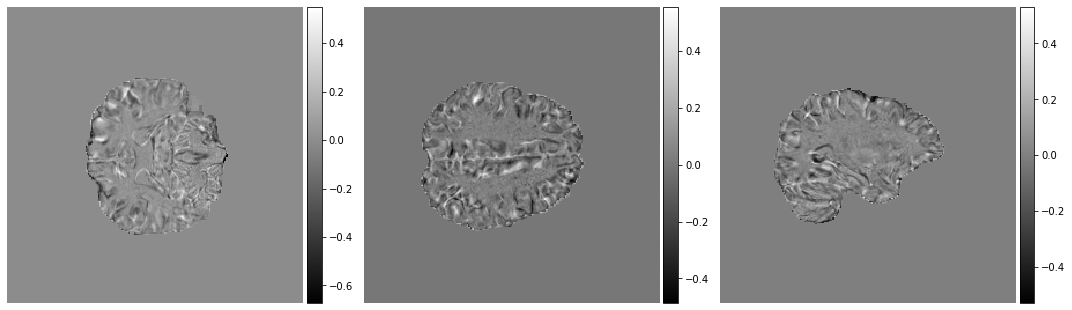

In [14]:
import neurite as ne

img = moving - fixed

images = [img[0, :, :, 100,0], img[0, :, 100, :,0], img[0, 100, :, :,0]]

# visualize
ne.plot.slices(images, cmaps=['gray'], do_colorbars=True);


img = warped - fixed

images = [img[0, :, :, 100,0], img[0, :, 100, :,0], img[0, 100, :, :,0]]

# visualize
ne.plot.slices(images, cmaps=['gray'], do_colorbars=True);



In [ ]:
dice.mean()